In [10]:
# Import Required Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel,DotProduct,ExpSineSquared
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
# Read Data
data = pd.read_csv('forestfires.csv')

data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


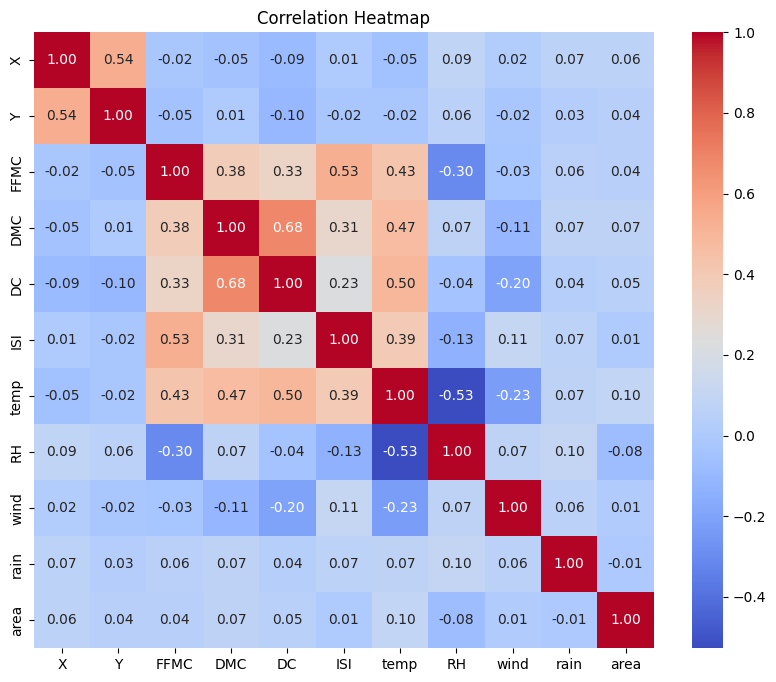

In [12]:
# Correlation Matrix
# Select only numerical columns
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
correlation_matrix = numerical_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

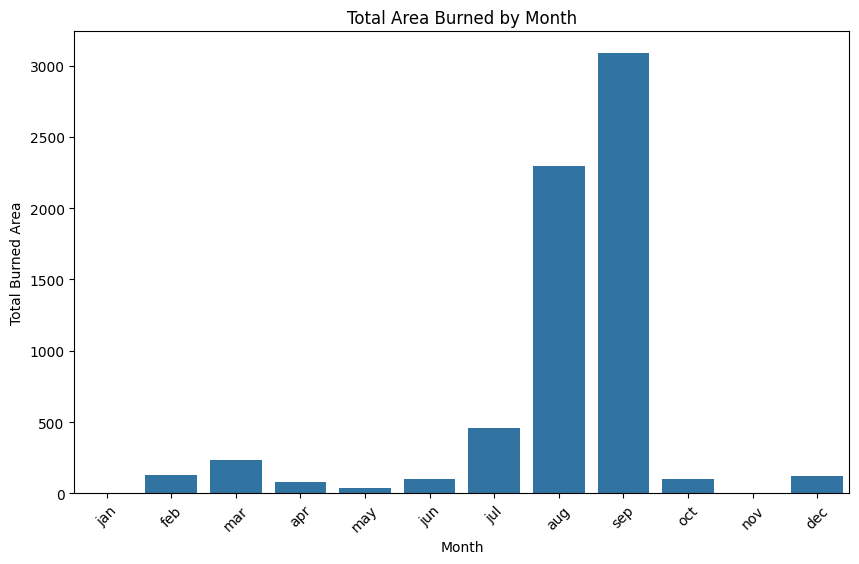

In [13]:
# Bar Plot of area burnt by month
# Group by month and sum the area
month_area = data.groupby('month')['area'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='area', data=month_area, order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
plt.title('Total Area Burned by Month')
plt.xlabel('Month')
plt.ylabel('Total Burned Area')
plt.xticks(rotation=45)
plt.show()

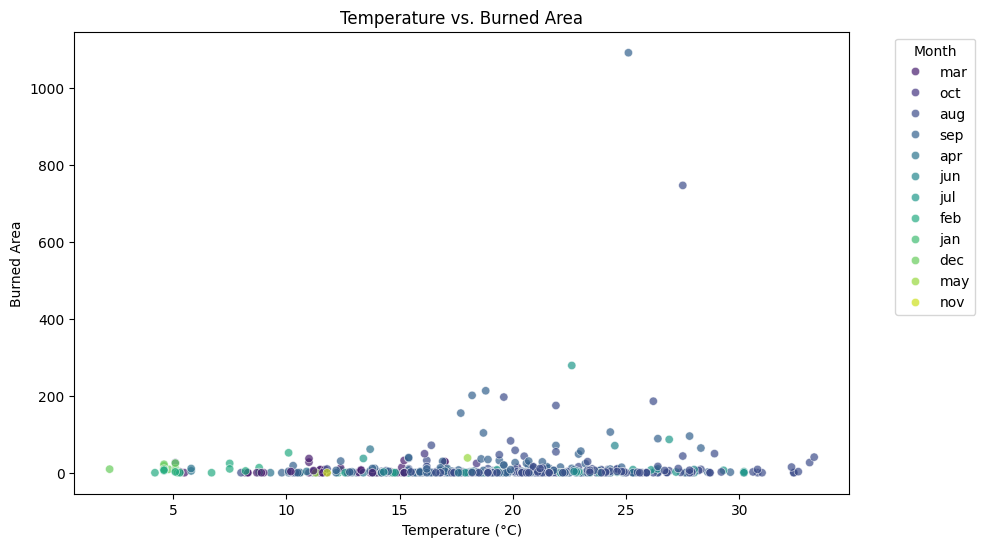

In [14]:
# Scatter plot of temperature and area
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='temp', y='area', hue='month', palette='viridis', alpha=0.7)
plt.title('Temperature vs. Burned Area')
plt.xlabel('Temperature (°C)')
plt.ylabel('Burned Area')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


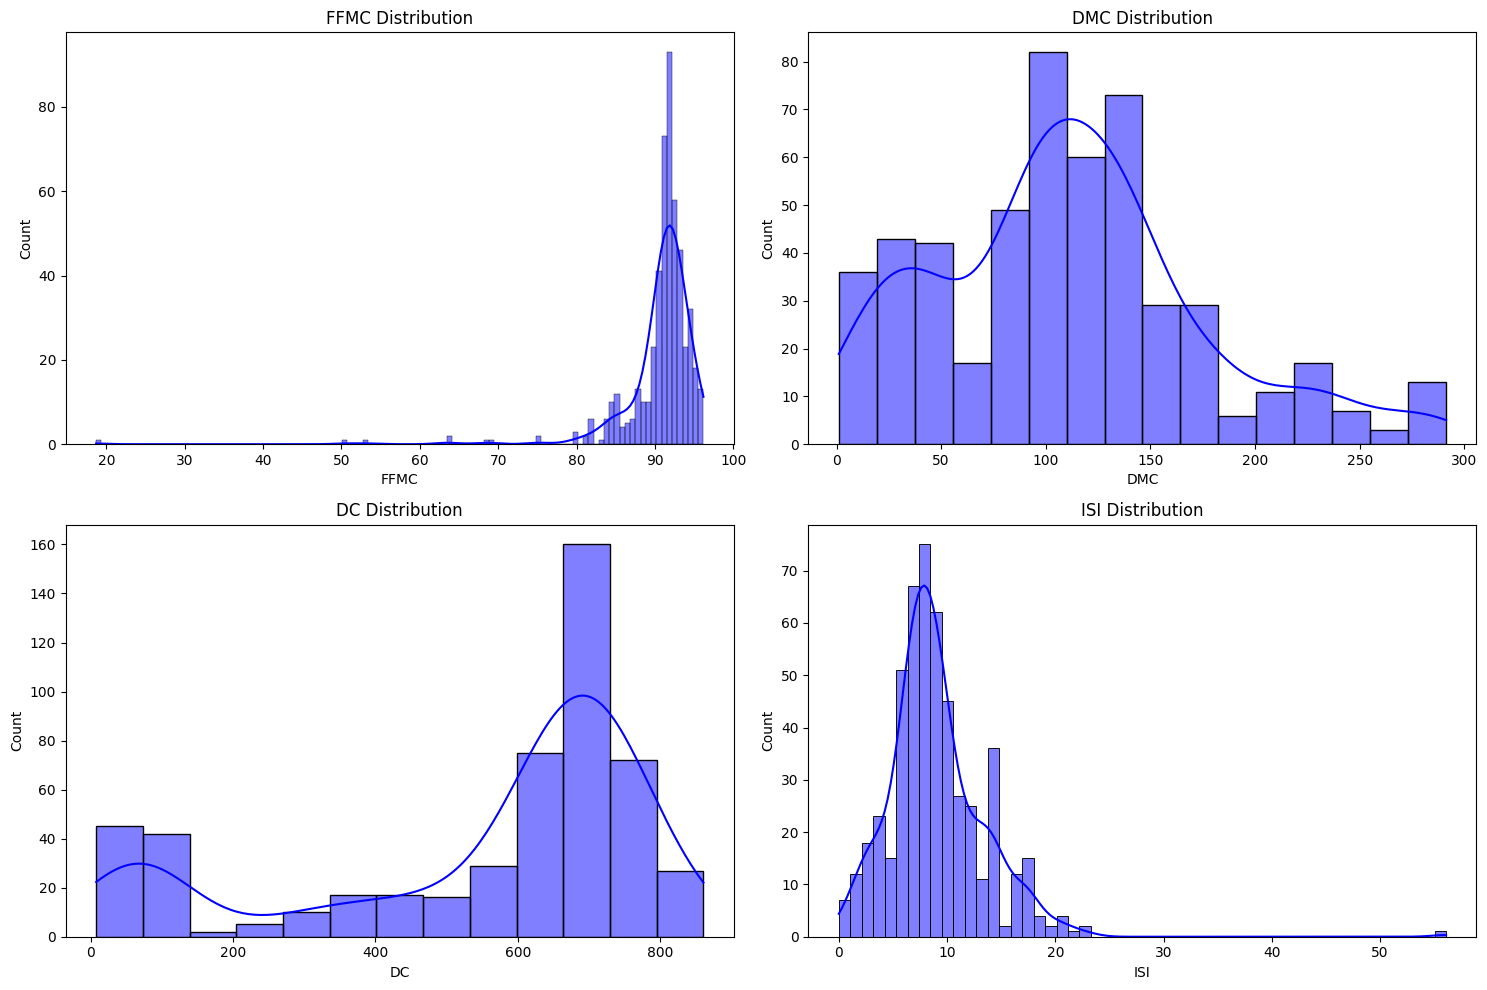

In [15]:
# Fire weather index distribution

indices = ['FFMC', 'DMC', 'DC', 'ISI']

# Plot distribution of Fire Weather Indices
plt.figure(figsize=(15, 10))
for i, index in enumerate(indices, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[index], kde=True, color='blue')
    plt.title(f'{index} Distribution')
plt.tight_layout()
plt.show()

In [16]:
# Feature Selection
# Drop Non-Important Columns
data = data.drop(['month', 'day'], axis=1)
data.head()

# Calculate Z-scores
data['z_score'] = (data['area'] - data['area'].mean()) / data['area'].std()

# Filter out outliers
cleaned_data = data[abs(data['z_score']) < 3]

In [17]:
# Set Features
X = cleaned_data.iloc[:, 0:9]
X.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8


In [18]:
# Set Targets
y = cleaned_data.iloc[:, 10]
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: area, dtype: float64

In [19]:
# Define Scaler
scaler = StandardScaler()

In [20]:
# Scale Data
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 1.01304043,  0.57054752, -0.80168858, ..., -1.83604678,
         0.40817226,  1.49492476],
       [ 1.01304043, -0.24474741, -0.00634247, ..., -0.14704903,
        -0.69486042, -1.73763275],
       [ 1.01304043, -0.24474741, -0.00634247, ..., -0.73302784,
        -0.69486042, -1.51469775],
       ...,
       [ 1.01304043, -0.24474741, -1.63318679, ...,  0.40446043,
         1.57248454,  1.49492476],
       [-1.58757545, -0.24474741,  0.68054735, ...,  1.16278595,
        -0.14334408, -0.00988649],
       [ 0.57960445, -1.06004234, -2.01278379, ..., -1.21559863,
        -0.81741961,  0.26878226]])

In [21]:
# Split the data into training and test sets# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

In [22]:
# Define the Gaussian Process Regression model with a kernel

kernel = (
    # Long-term trend (Dot product captures a rising trend with the given sigma_0)
    DotProduct(sigma_0=1.0) 
    
    # Seasonal variations (Adjusting length_scale and periodicity for more control)
    + 0.2 * ExpSineSquared(length_scale=10, periodicity=15)  # Adjust length_scale for smoother seasonal variation
    
    # Additional short-term fluctuations (Captures more fine-grained changes)
    + 0.1 * RBF(length_scale=2) * ExpSineSquared(length_scale=0.1, periodicity=50)  # Minor fluctuations
    
    # White noise (Noise level adjusted to prevent overfitting)
    + WhiteKernel(noise_level=0.05)
)
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1, alpha=1)

In [23]:
# Train the GPR model
model.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1,
                         kernel=DotProduct(sigma_0=1) + 0.447**2 * ExpSineSquared(length_scale=10, periodicity=15) + 0.316**2 * RBF(length_scale=2) * ExpSineSquared(length_scale=0.1, periodicity=50) + WhiteKernel(noise_level=0.05),
                         n_restarts_optimizer=10, random_state=1)

In [25]:
# Make predictions on the test set
y_pred, y_std = model.predict(X_test, return_std=True)

In [26]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("mse", mse)
print("r2", r2)

mse 274.29096897320557
r2 0.005034586806810903


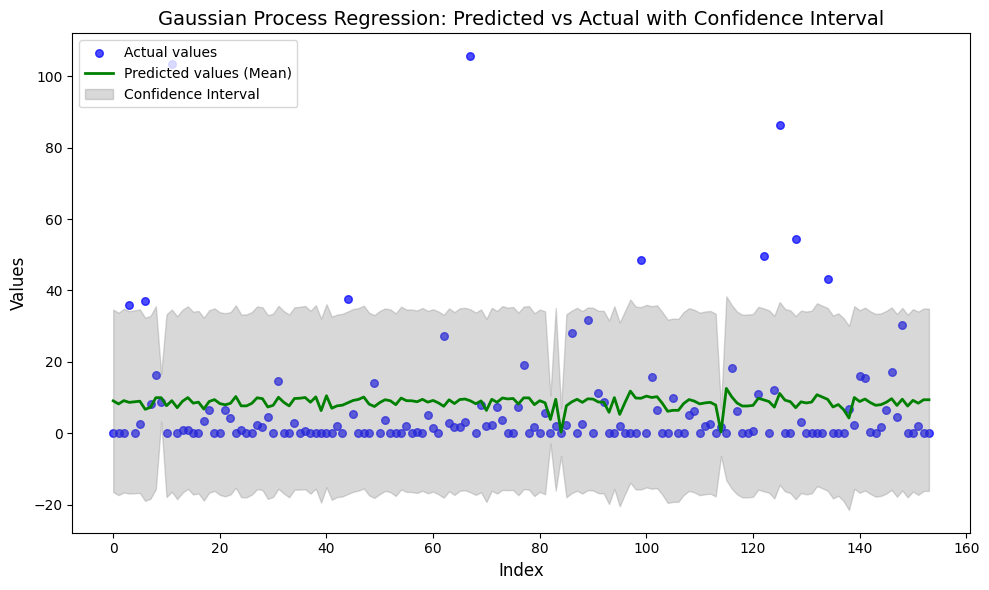

In [27]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting the scatter plot
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual values', s=30, alpha=0.7)

# Plotting the mean predicted values
plt.plot(range(len(y_pred)), y_pred, color='green', label='Predicted values (Mean)', linestyle='-', linewidth=2)

# Plotting the confidence interval
plt.fill_between(range(len(y_pred)), y_pred - y_std, y_pred + y_std, color='gray', alpha=0.3, label='Confidence Interval')

# Clean up plot appearance
plt.xlabel('Index', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Gaussian Process Regression: Predicted vs Actual with Confidence Interval', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.tight_layout()

plt.show()

In [28]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')

c:\Users\LEGION\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [29]:
print("Cross-Validation R2 Scores:", scores)
print("Mean R2:", scores.mean())

Cross-Validation R2 Scores: [-0.04993786 -0.15032099 -0.02806612 -0.0169478  -0.00405848  0.00335834
 -1.22518576 -0.11325171 -0.02077068 -0.03720951]
Mean R2: -0.1642390559997679


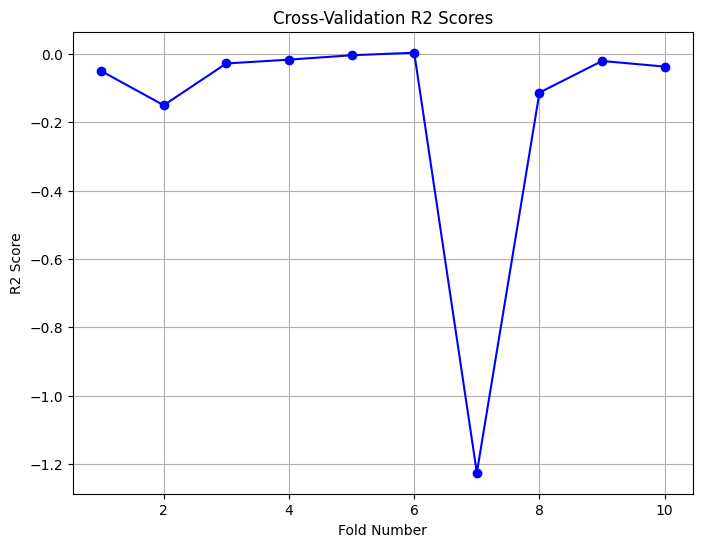

In [30]:
# Plotting the R2 scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation R2 Scores')
plt.xlabel('Fold Number')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()


c:\Users\LEGION\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\LEGION\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpc.py:476: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


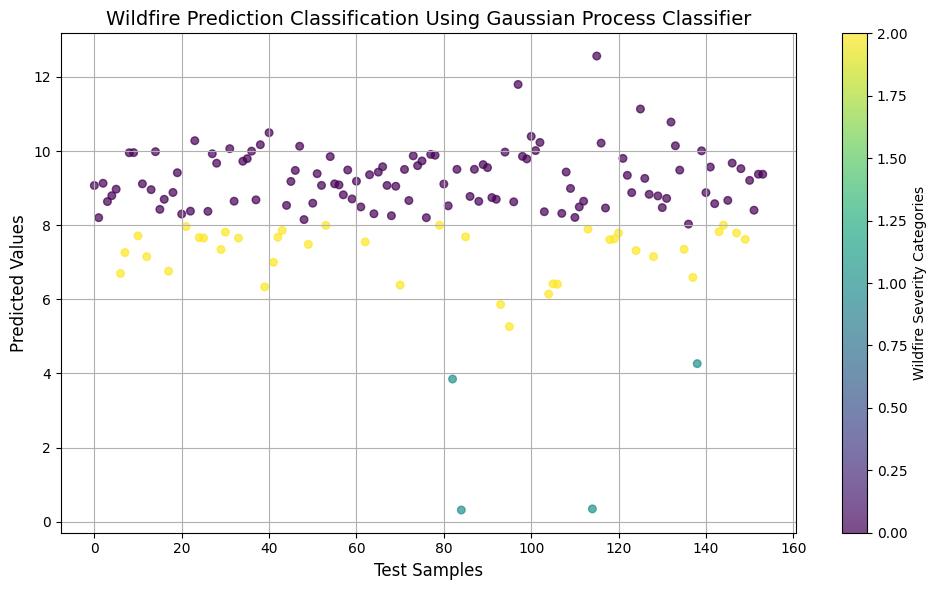

Predicted Categories: ['High' 'High' 'High' 'High' 'High' 'High' 'Medium' 'Medium' 'High' 'High'
 'Medium' 'High' 'Medium' 'High' 'High' 'High' 'High' 'Medium' 'High'
 'High' 'High' 'Medium' 'High' 'High' 'Medium' 'Medium' 'High' 'High'
 'High' 'Medium' 'Medium' 'High' 'High' 'Medium' 'High' 'High' 'High'
 'High' 'High' 'Medium' 'High' 'Medium' 'Medium' 'Medium' 'High' 'High'
 'High' 'High' 'High' 'Medium' 'High' 'High' 'High' 'Medium' 'High' 'High'
 'High' 'High' 'High' 'High' 'High' 'High' 'Medium' 'High' 'High' 'High'
 'High' 'High' 'High' 'High' 'Medium' 'High' 'High' 'High' 'High' 'High'
 'High' 'High' 'High' 'Medium' 'High' 'High' 'Low' 'High' 'Low' 'Medium'
 'High' 'High' 'High' 'High' 'High' 'High' 'High' 'Medium' 'High' 'Medium'
 'High' 'High' 'High' 'High' 'High' 'High' 'High' 'High' 'Medium' 'Medium'
 'Medium' 'High' 'High' 'High' 'High' 'High' 'High' 'Medium' 'Low' 'High'
 'High' 'High' 'Medium' 'Medium' 'Medium' 'High' 'High' 'High' 'Medium'
 'High' 'High' 'High' 'Medium' 

In [17]:
# Define some categories for wildfire classification (these thresholds can be adjusted)
categories = ["Low", "Medium", "High", "Severe"]

# Example: categorizing based on the value ranges in y_pred
def categorize_wildfire(values):
    """
    Categorize values into wildfire categories based on predefined thresholds.
    """
    categories = ["Low", "Medium", "High", "Severe"]
    thresholds = [0, 5, 8, 15]  # Adjust the thresholds based on the expected range of values
    categorized = []

    for value in values:
        if value <= thresholds[1]:
            categorized.append(categories[0])  # Low
        elif value <= thresholds[2]:
            categorized.append(categories[1])  # Medium
        elif value <= thresholds[3]:
            categorized.append(categories[2])  # High
        else:
            categorized.append(categories[3])  # Severe
    return np.array(categorized)

# Categorize y_pred values
y_pred_categories = categorize_wildfire(y_pred)

# Encode categories as numeric labels for classification
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_pred_categories)

# Reshape y_pred for use in the Gaussian Process Classifier (it should be 2D)
X_train = y_pred.reshape(-1, 1)  # For this example, just use y_pred as the feature
y_train = y_encoded  # Target categories

# Train the Gaussian Process Classifier
kernel = 1.0 * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=kernel)
gpc.fit(X_train, y_train)

# Predict the categories for the given predictions (y_pred)
y_pred_class = gpc.predict(X_train)

# Decode the predicted class labels back to category names
y_pred_class_labels = label_encoder.inverse_transform(y_pred_class)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plotting the predicted categories
plt.scatter(range(len(y_pred)), y_pred, c=y_pred_class, cmap="viridis", s=30, alpha=0.7)
plt.colorbar(label='Wildfire Severity Categories')

# Adding the legend and title
plt.title("Wildfire Prediction Classification Using Gaussian Process Classifier", fontsize=14)
plt.xlabel("Test Samples", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

# Display the predicted categories
print("Predicted Categories:", y_pred_class_labels)
